<a href="https://colab.research.google.com/github/Shreyashi14/Mental-Health-Assistance-Project/blob/main/CL%26NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries

In [ ]:
import nltk
import torch
from sklearn.model_selection import train_test_split
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Model:

In [ ]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Device set to use cpu


Model Training

In [ ]:
data = {
    "I feel so lonely and sad.": "sadness",
    "I can't sleep at night.": "insomnia",
    "I am feeling very anxious these days.": "anxiety",
    "I don't find joy in anything anymore.": "depression",
    "I'm so stressed about my exams.": "anxiety",
    "Life is beautiful! I am happy.": "positive",
    "I get panic attacks often.": "panic",
    "I have lost interest in my hobbies.": "depression",
    "I have trouble concentrating.": "depression",
    "I feel energetic and optimistic.": "positive",
    "I am constantly worried about everything.": "anxiety",
    "I want someone to talk to.": "support"
}

X = list(data.keys())
y = list(data.values())

y = [label.replace('depressi', 'depression') for label in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)

model = MultinomialNB()
model.fit(X_train_vectors, y_train)

X_test_vectors = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vectors)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     anxiety       0.33      1.00      0.50         1
depressionon       1.00      1.00      1.00         1
    positive       0.00      0.00      0.00         1
     sadness       0.00      0.00      0.00         1

    accuracy                           0.50         4
   macro avg       0.33      0.50      0.38         4
weighted avg       0.33      0.50      0.38         4



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(le.classes_)
)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors="pt")

train_labels = torch.tensor(y_train_enc)
test_labels = torch.tensor(y_test_enc)

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)

optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

epochs = 3

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        batch = [item.to(device) for item in batch]
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch+1} complete! Loss: {loss.item():.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 complete! Loss: 2.0472
Epoch 2 complete! Loss: 1.9005
Epoch 3 complete! Loss: 1.7062


Performance Evaluation

              precision    recall  f1-score   support

     anxiety       0.25      1.00      0.40         1
depressionon       0.00      0.00      0.00         1
    insomnia       0.00      0.00      0.00         1
       panic       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.06      0.25      0.10         4
weighted avg       0.06      0.25      0.10         4



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 4, does not match size of target_names, 7
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

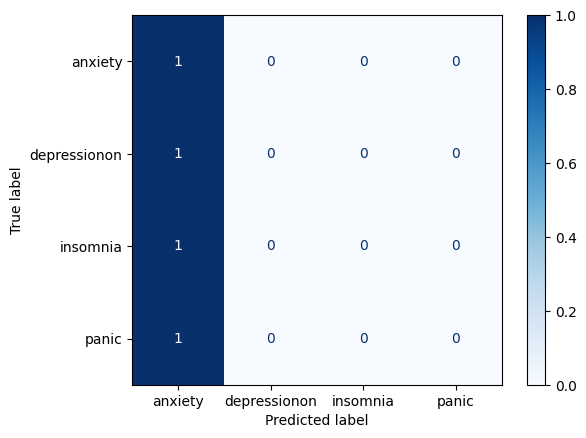

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

true_labels = np.array(true_labels)
predictions = np.array(predictions)

print(classification_report(true_labels, predictions, labels=np.unique(true_labels), target_names=le.classes_))

cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_[:len(np.unique(true_labels))])
disp.plot(cmap='Blues')

Chat Function

In [ ]:
import random

response_bank = {
    "sadness": [
        "I'm sorry you're feeling this way. Remember, it's okay to have tough days. 💙",
        "Would you like me to suggest a breathing exercise?",
        "It's important to take care of yourself. I'm here for you."
    ],
    "anxiety": [
        "Let's take a deep breath together. 🌬️ You're doing your best.",
        "Anxiety often passes like a wave. Do you want a quick calming technique?",
        "You're not alone in this. It's okay to feel uneasy sometimes."
    ],
    "positive": [
        "That's wonderful to hear! Keep shining. ✨",
        "I'm happy you're feeling good! What made you feel this way?",
        "Spreading positivity is contagious. Thank you for sharing. 💖"
    ],
    "insomnia": [
        "Rest is so important. Would you like some tips for better sleep?",
        "A calming nighttime routine might help. Would you like one?",
        "Maybe some gentle meditation could help you sleep. 🌙"
    ],
    "panic": [
        "You're safe. Let's try a grounding exercise if you want. 🧘",
        "Would you like a technique to help slow your heartbeat?",
        "Remember, panic attacks pass even if they feel scary. You're strong."
    ],
    "depression": [
        "I'm here to listen. You matter more than you know. ❤️",
        "Would you like some motivational quotes?",
        "It's brave to talk about how you feel. You're not alone."
    ],
    "support": [
        "I'm here for you. How can I support you today?",
        "Talking can be very healing. Share as much as you like. 🌸",
        "Your feelings are valid. Let's work through them together."
    ]
}

def analyze_emotion(text):

    text = text.lower()

    if "sad" in text or "down" in text or "blue" in text:
        return "sadness"
    elif "anxious" in text or "nervous" in text or "worried" in text:
        return "anxiety"
    elif "happy" in text or "joy" in text or "excited" in text:
        return "positive"
    elif "cant sleep" in text or "insomnia" in text or "tired" in text:
        return "insomnia"
    elif "panic" in text or "scared" in text or "overwhelmed" in text:
        return "panic"
    elif "depressed" in text or "hopeless" in text or "empty" in text:
        return "depression"
    elif "help" in text or "support" in text or "care" in text:
        return "support"
    else:
        return "neutral"

def chat():
    print("Mental Health Bot 🧠: Hello! I'm here to support you. How are you feeling today?")

    while True:
        user_input = input("You: ")

        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("Mental Health Bot 🧠: Take care of yourself! 💛 Goodbye!")
            break

        emotion = analyze_emotion(user_input)
        print(f"Mental Health Bot 🧠: I detected that you might be feeling {emotion}. Let's talk about it.")

        if emotion in response_bank:
            response = random.choice(response_bank[emotion])
            print(f"Mental Health Bot 🧠: {response}")
        else:
            print("Mental Health Bot 🧠: I'm here to listen. Could you tell me more?")

        continue_convo = input("Would you like to continue talking about this or talk about something else? (continue/exit): ").lower()

        if continue_convo == "exit":
            print("Mental Health Bot 🧠: Take care of yourself! 💛 Goodbye!")
            break
        elif continue_convo == "continue":
            print(f"Mental Health Bot 🧠: Let's continue talking about {emotion}. I'm here to support you!")
        else:
            print("Mental Health Bot 🧠: I'm here for you anytime. If you want to talk later, just reach out!")
            break

Run

In [ ]:
chat()

Mental Health Bot 🧠: Hello! I'm here to support you. How are you feeling today?
You: I am feeling a bit anxious today
Mental Health Bot 🧠: I detected that you might be feeling anxiety. Let's talk about it.
Mental Health Bot 🧠: Anxiety often passes like a wave. Do you want a quick calming technique?
Would you like to continue talking about this or talk about something else? (continue/exit): continue
Mental Health Bot 🧠: Let's continue talking about anxiety. I'm here to support you!
You: can you suggest something
Mental Health Bot 🧠: I detected that you might be feeling neutral. Let's talk about it.
Mental Health Bot 🧠: I'm here to listen. Could you tell me more?
Would you like to continue talking about this or talk about something else? (continue/exit): I am feeling sad
Mental Health Bot 🧠: I'm here for you anytime. If you want to talk later, just reach out!
